# AlexNet

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [3]:
# Define paths to the dataset directories
train_dir = 'fruit30_split/train'
val_dir = 'fruit30_split/val'

In [4]:
# Updated data augmentation transformations
transform_augmented = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the transformations for data preprocessing
transform_normal  = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# Load augmented training dataset
train_dataset_augmented = torchvision.datasets.ImageFolder(root=train_dir, transform=transform_augmented)
val_dataset = torchvision.datasets.ImageFolder(root=val_dir, transform=transform_normal)

# Split the augmented training dataset into new training and validation sets (9:1 ratio)
train_size = int(0.9 * len(train_dataset_augmented))
val_size = len(train_dataset_augmented) - train_size
new_train_dataset, new_val_dataset = random_split(train_dataset_augmented, [train_size, val_size])

# Create data loaders with shuffled training batches
train_loader_augmented = DataLoader(new_train_dataset, batch_size=32, shuffle=True)
val_loader_augmented = DataLoader(new_val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [6]:
# Define the AlexNet architecture
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [7]:
# Instantiate the model
num_classes = len(train_dataset_augmented.classes)
model = AlexNet(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training and validation loop
num_epochs = 30
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

In [8]:
for epoch in range(num_epochs):
    model.train()
    running_loss, running_corrects = 0.0, 0
    for inputs, labels in train_loader_augmented:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_loader_augmented.dataset)
    epoch_acc = running_corrects.double() / len(train_loader_augmented.dataset)
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc.item())
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

    model.eval()
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader_augmented:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
    val_loss = val_loss / len(val_loader_augmented.dataset)
    val_acc = val_corrects.double() / len(val_loader_augmented.dataset)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc.item())
    print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}\n")

Epoch 1/30 - Train Loss: 3.1896, Train Acc: 0.0660
Validation Loss: 2.9590, Validation Acc: 0.0594

Epoch 2/30 - Train Loss: 2.6277, Train Acc: 0.1539
Validation Loss: 2.6208, Validation Acc: 0.1689

Epoch 3/30 - Train Loss: 2.3918, Train Acc: 0.2126
Validation Loss: 2.5209, Validation Acc: 0.2123

Epoch 4/30 - Train Loss: 2.2332, Train Acc: 0.2659
Validation Loss: 2.2166, Validation Acc: 0.2785

Epoch 5/30 - Train Loss: 2.0455, Train Acc: 0.3360
Validation Loss: 2.1513, Validation Acc: 0.2740

Epoch 6/30 - Train Loss: 1.9815, Train Acc: 0.3510
Validation Loss: 2.0673, Validation Acc: 0.3242

Epoch 7/30 - Train Loss: 1.8651, Train Acc: 0.3970
Validation Loss: 2.0229, Validation Acc: 0.3516

Epoch 8/30 - Train Loss: 1.7849, Train Acc: 0.4143
Validation Loss: 1.9923, Validation Acc: 0.3767

Epoch 9/30 - Train Loss: 1.7147, Train Acc: 0.4343
Validation Loss: 1.8917, Validation Acc: 0.3836

Epoch 10/30 - Train Loss: 1.6755, Train Acc: 0.4498
Validation Loss: 2.1669, Validation Acc: 0.3562


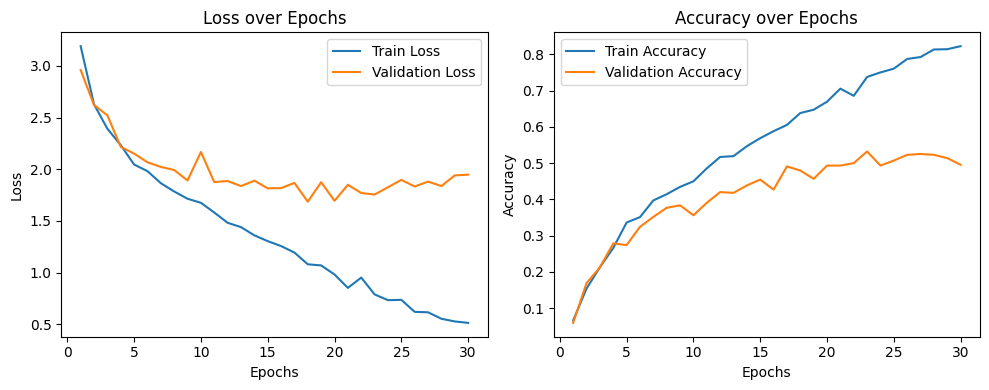

In [9]:
# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.tight_layout()
plt.show()

In [10]:
# Evaluate the model on the test set
model.eval()
test_loss, test_corrects = 0.0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)
test_loss = test_loss / len(test_loader.dataset)
test_acc = test_corrects.double() / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test Loss: 1.8568, Test Acc: 0.5371
